<a href="https://colab.research.google.com/github/Lakshmi-krishna-vr/Computational_Optimization_/blob/main/LPP_mod3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Problem 1: The “Hello World” of CPM

Scenario: A simple linear workflow with one parallel branch.

Activity Data:



| Activity | Predecessors | Duration (Days) | Start Day | Finish Day |
| :--- | :--- | :--- | :--- | :--- |
| **A** | - | 3 | 0 | 3 |
| **B** | A | 4 | 3 | 7 |
| **C** | A | 2 | 3 | 5 |
| **D** | B, C | 5 | 7 | 12 |


Step 1: Forward Pass (Find ES, EF)

A: Start at 0. Duration $n\ 3. \rightarrow EF = 3.$

**Step 1: Forward Pass (Find ES, EF)**

* **A:** Start at 0. Duration 3. $\rightarrow EF = 3.$
* **B:** Predecessor A (ends at 3). Start at 3. Duration 4. $\rightarrow EF = 7.$
* **C:** Predecessor A (ends at 3). Start at 3. Duration 2. $\rightarrow EF = 5.$
* **D:** Predecessors B (ends 7) and C (ends 5).
    * *Rule*: We must wait for the **slowest** one. $\max(7, 5) = 7.$
    * Start at 7. Duration 5. $\rightarrow EF = 12.$

**Project Duration:** 12 Days.

**Step 2: Backward Pass (Find LF, LS)**

* **D:** End at 12. Duration 5. $\rightarrow LS = 12 - 5 = 7.$
* **B:** Successor D (starts at 7). Must finish by 7. Duration 4. $\rightarrow LS = 7 - 4 = 3.$
* **C:** Successor D (starts at 7). Must finish by 7. Duration 2. $\rightarrow LS = 7 - 2 = 5.$
* **A:** Successors B (starts 3) and C (starts 5).
    * *Rule*: Must be done in time for the **earliest** requirement. $\min(3, 5) = 3.$
    * Must finish by 3. Duration 3. $\rightarrow LS = 0.$
    

Step 3 & 4: Float & Critical Path
| Activity | Duration | ES | EF | LS | LF | Float (LS-ES) | Critical? |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| **A** | 3 | 0 | 3 | 0 | 3 | 0 | **Yes** |
| **B** | 4 | 3 | 7 | 3 | 7 | 0 | **Yes** |
| **C** | 2 | 3 | 5 | 5 | 7 | 2 | No |
| **D** | 5 | 7 | 12 | 7 | 12 | 0 | **Yes** |

**Critical Path:** A $\rightarrow$ B $\rightarrow$ D

--- CPM Schedule Table ---
   Duration  ES (Early Start)  EF (Early Finish)  LS (Late Start)  \
A         3                 0                  3                0   
B         4                 3                  7                3   
C         2                 3                  5                5   
D         5                 7                 12                7   

   LF (Late Finish)  Slack Critical?  
A                 3      0       Yes  
B                 7      0       Yes  
C                 7      2        No  
D                12      0       Yes  
------------------------------
Total Project Duration: 12 Days
Critical Path: A -> B -> D


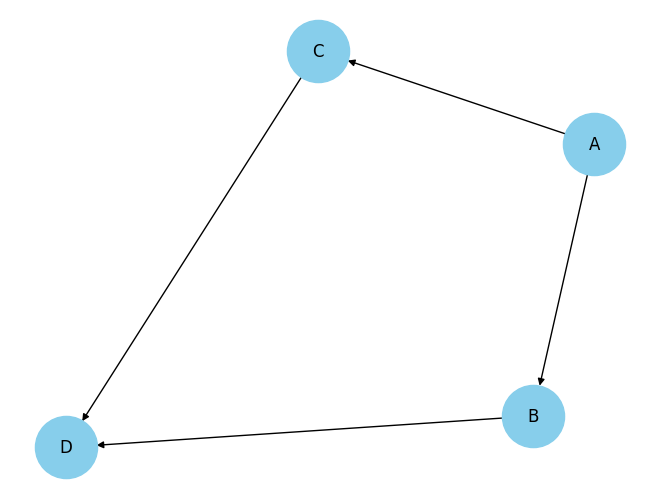

In [ ]:
import networkx as nx
import pandas as pd

# 1. Define the Project Data
tasks = {
    'A': {'duration': 3, 'predecessors': []},
    'B': {'duration': 4, 'predecessors': ['A']},
    'C': {'duration': 2, 'predecessors': ['A']},
    'D': {'duration': 5, 'predecessors': ['B', 'C']}
}

# 2. Build the Network Graph
G = nx.DiGraph()
for task, data in tasks.items():
    G.add_node(task, duration=data['duration'])
    for pred in data['predecessors']:
        G.add_edge(pred, task)

# ---------------------------------------------------------
# 3. Forward Pass (Calculate Early Start & Early Finish)
# ---------------------------------------------------------
# We iterate in topological order to ensure predecessors are processed first
early_start = {}
early_finish = {}

for task in nx.topological_sort(G):
    # ES is max of predecessor's EF. If no predecessors, ES = 0
    predecessors = list(G.predecessors(task))
    if not predecessors:
        es = 0
    else:
        es = max(early_finish[p] for p in predecessors)

    duration = G.nodes[task]['duration']
    ef = es + duration

    early_start[task] = es
    early_finish[task] = ef

project_duration = max(early_finish.values())

# ---------------------------------------------------------
# 4. Backward Pass (Calculate Late Start & Late Finish)
# ---------------------------------------------------------
# We iterate in reverse topological order
late_start = {}
late_finish = {}

for task in reversed(list(nx.topological_sort(G))):
    successors = list(G.successors(task))

    # LF is min of successor's LS. If no successors, LF = Project Duration
    if not successors:
        lf = project_duration
    else:
        lf = min(late_start[s] for s in successors)

    duration = G.nodes[task]['duration']
    ls = lf - duration

    late_finish[task] = lf
    late_start[task] = ls

# ---------------------------------------------------------
# 5. Calculate Slack & Identify Critical Path
# ---------------------------------------------------------
slack = {}
critical_path = []

for task in tasks:
    s = late_start[task] - early_start[task]
    slack[task] = s
    if s == 0:
        critical_path.append(task)

# ---------------------------------------------------------
# 6. Display Results
# ---------------------------------------------------------
# Create a DataFrame for a clean CPM Table
df = pd.DataFrame({
    'Duration': [tasks[t]['duration'] for t in tasks],
    'ES (Early Start)': [early_start[t] for t in tasks],
    'EF (Early Finish)': [early_finish[t] for t in tasks],
    'LS (Late Start)': [late_start[t] for t in tasks],
    'LF (Late Finish)': [late_finish[t] for t in tasks],
    'Slack': [slack[t] for t in tasks],
    'Critical?': ['Yes' if s == 0 else 'No' for s in slack.values()]
}, index=tasks.keys())

print("--- CPM Schedule Table ---")
print(df)
print("-" * 30)
print(f"Total Project Duration: {project_duration} Days")
print(f"Critical Path: {' -> '.join(critical_path)}")

# Visualize the Network
import matplotlib.pyplot as plt
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue')
plt.show()

## Problem 2: The Bottleneck
Scenario: Software Development. Coding takes longer than Documentation.

Activity Data:
| Activity | Description | Predecessors | Duration | ES | EF | LS | LF | Float | Critical? |
| :---: | :--- | :--- | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| **S** | Start Specs | - | 2 | 0 | 2 | 0 | 2 | 0 | **Yes** |
| **C** | Code Module | S | 8 | 2 | 10 | 2 | 10 | 0 | **Yes** |
| **D** | Write Docs | S | 3 | 2 | 5 | 7 | 10 | 5 | No |
| **T** | Testing | C, D | 4 | 10 | 14 | 10 | 14 | 0 | **Yes** |

**Critical Path:** S $\rightarrow$ C $\rightarrow$ T
**Project Duration:** 14 Days